In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports and toolboxes needed for workflow
# System imports
import os
import sys

# Mathematical imports
import numpy as np
import math

# To make this notebook's output stable across runs
np.random.seed(42)

# Data structure imports
import csv
from collections import Counter # https://docs.python.org/2/library/collections.html
import re
import pandas as pd
from pandas import set_option
set_option('display.max_columns',400)


# Machine Learning and Statistical imports
import scipy
from sklearn.cluster import KMeans


# Computer Vision imports
import cv2
import PIL
from PIL import Image
from skimage.color import rgb2lab, deltaE_cie76


# Visualization imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import image as img
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams['figure.figsize'] = (100,100)

import seaborn as sns

from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource, ColorBar
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap
from bokeh.plotting import figure
output_notebook()

# Where to save the figures
PROJECT_ROOT_DIR = './Users/peterflaming/IODP/Figures/'
WORK_ID = ['Extraction', 'Transform', 'Load', 'Results']

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "Figures", WORK_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")



Loading BokehJS ...

In [3]:
%%time
mydir='/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/'

def createFileList(myDir, format='.jpg'):
    fileList = []
    print('\nCurrent Working Directory:\n', myDir, end='\n')
    
    for root, dirs, files in os.walk(myDir, topdown=False):
        for file in files:
            if file.endswith(format):
                fullName = os.path.join(root, file)
                fileList.append(fullName)
        print('\nList of Core Images:\n', fileList, end='\n')
    return fileList

fileList = createFileList(mydir)


Current Working Directory:
 /Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/

List of Core Images:
 ['/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_002h_06_cropped.jpg', '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_003h_05_cropped.jpg', '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_001h_02_cropped.jpg', '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_002h_03_cropped.jpg', '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_001h_01_cropped.jpg', '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_003h_03_cropped.jpg', '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_001h_04_cropped.jpg', '/Users/peterflaming/Documents/GitHub/CoreSampl

In [4]:
%%time
# Sort and view the list of images
fileList.sort()
fileList

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 19.1 µs


['/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_001h_01_cropped.jpg',
 '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_001h_02_cropped.jpg',
 '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_001h_03_cropped.jpg',
 '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_001h_04_cropped.jpg',
 '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_002h_01_cropped.jpg',
 '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_002h_02_cropped.jpg',
 '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_002h_03_cropped.jpg',
 '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1313A-Core-Photos-cropped/1313a_002h_04_cropped.jpg',
 '/Users/peterflaming/Documents/GitHub/CoreSamples/Drill_Sites/1

In [5]:
%%time
# Read the Core Image data with OpenCV, which creates a list of NumPy arrays for each section of core 
images = [cv2.imread(file) for file in fileList]

CPU times: user 1.5 s, sys: 223 ms, total: 1.72 s
Wall time: 1.77 s


In [6]:
%%time
RGB_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

CPU times: user 225 ms, sys: 510 ms, total: 735 ms
Wall time: 310 ms


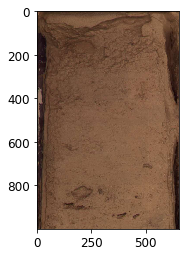

In [8]:
plt.imshow(RGB_images[0][0:1000])

In [22]:
RGB_df = pd.DataFrame(RGB_images)
RGB_df

,0
0,"[[[145, 105, 70], [147, 107, 72], [148, 108, 7..."
1,"[[[81, 66, 63], [74, 59, 56], [62, 48, 45], [5..."
2,"[[[17, 7, 15], [17, 7, 15], [17, 7, 15], [17, ..."
3,"[[[42, 21, 40], [40, 19, 38], [38, 19, 39], [4..."
4,"[[[251, 215, 217], [248, 212, 214], [245, 206,..."
5,"[[[94, 76, 76], [93, 75, 75], [94, 75, 77], [9..."
6,"[[[0, 7, 2], [13, 23, 15], [37, 44, 37], [58, ..."
7,"[[[14, 7, 14], [4, 2, 7], [20, 21, 23], [7, 18..."
8,"[[[76, 56, 57], [85, 65, 66], [95, 75, 77], [9..."
9,"[[[90, 85, 89], [73, 68, 72], [70, 67, 74], [9..."


In [24]:
print('Matrix Shape:', RGB_df.shape, 'Vector Shape:', RGB_df[0][0].shape)

Matrix Shape: (18, 1) Vector Shape: (14951, 651, 3)


In [25]:
%%time
x = range(0, 1000000)
y = RGB_df[0][0] 
# z = 
# z1 = 
# z2 = 

p = figure(title='Section 1 A Mean Color Variations of Pixels', plot_width=980, plot_height=600)
r = p.line(x, y, color='red', line_width=0.5,legend='Red')
# r1 = p.line(x, z, color='green', line_width=0.5,legend='Green')
# r2 = p.line(x, z1, color='blue', line_width=0.5,legend='Blue')
# r3 = p.line(x, z2, color='gray', line_width=0.5,legend='Gray')

p.xaxis.axis_label = 'Pixel Values with Depth (mm)'
p.yaxis.axis_label = 'Colorspace (0-255)'
p.legend.location = 'top_left'
show(p)

RuntimeError: Columns need to be 1D (y is not)

In [ ]:
data = pd.read_csv('./CoreSample/Predictions/Final.csv')

data.describe()